In [1]:
from Models.TensorGen import BeamSearchOptimized as BeamSearch
from Models.Configure import VanillaTransformerConfig, prepare_model
from Data.Dataset import RoutesDataset
from Utils.PostProcess import BeamResultType, find_valid_paths, process_paths

import torch
import yaml
from pathlib import Path
from rdkit import RDLogger, Chem
from tqdm import tqdm

RDLogger.DisableLog("rdApp.*")

data_path = Path.cwd() / "Data"
processed_path = data_path / "Processed"
ckpt_path = data_path / "Checkpoints"
fig_path = data_path / "Figures"

# Load Model and Dataset Class

In [2]:
with open(processed_path / "character_dictionary.yaml", "rb") as file:
    data = yaml.safe_load(file)
    idx_to_token = data["invdict"]
    token_to_idx = data["smiledict"]
    product_max_length = data["product_max_length"]
    sm_max_length = data["sm_max_length"]
    
rds = RoutesDataset()
rds.token_to_idx = token_to_idx
rds.seq_pad_index = 52

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_name = "van_6x3_6x3_final.ckpt"

van_enc_conf = VanillaTransformerConfig(
    input_dim=53,
    output_dim=53,
    input_max_length=145 + 135,
    output_max_length=1074 + 1,  # 1074 is max length
    pad_index=52,
    n_layers=6,
    ff_mult=3,
    attn_bias=False,
    ff_activation="gelu",
    hid_dim=256,
)
van_dec_conf = VanillaTransformerConfig(
    input_dim=53,
    output_dim=53,
    input_max_length=145 + 135,
    output_max_length=1074 + 1,  # 1074 is max length
    pad_index=52,
    n_layers=6,
    ff_mult=3,
    attn_bias=False,
    ff_activation="gelu",
    hid_dim=256,
)
model = prepare_model(enc_config=van_enc_conf, dec_config=van_dec_conf)

ckpt_torch = torch.load(ckpt_path / ckpt_name, map_location=device)
model.load_state_dict(ckpt_torch)
model.to(device)
model.eval();

The model has 9,857,333 trainable parameters


# User's Choice of Target Compounds, Steps, SM, and Beam Size

Your Canonical SMILES Target Compound: O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCN(CC2CC2)CC1
Your Canonical SMILES Starting Material: CCOC(=O)c1ccc(N)cc1


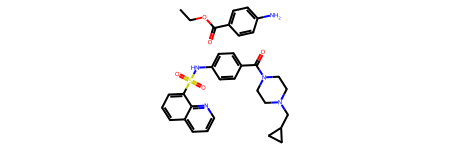

In [4]:
################### Modify this part
product_string = "O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCN(CC2CC2)CC1"
sm_string = "CCOC(=O)c1ccc(N)cc1"
n_steps = 3
beam_size = 50
###################
# Beam Search class
BSObject = BeamSearch(
    model=model,
    beam_size=beam_size,
    start_idx=0,
    pad_idx=52,
    end_idx=22,
    max_length=1074,
    idx_to_token=idx_to_token,
    device=device,
)
# Canonicalization
canonicalize = lambda smile: Chem.MolToSmiles(Chem.MolFromSmiles(smile), isomericSmiles=True)
product = canonicalize(product_string)
sm = canonicalize(sm_string)
print('Your Canonical SMILES Target Compound:', product)
print('Your Canonical SMILES Starting Material:', sm)
# Prepare torch objects
prod_tens = rds.smile_to_tokens(product, product_max_length)
sm_tens = rds.smile_to_tokens(sm, sm_max_length)
encoder_inp = torch.cat([prod_tens, sm_tens], dim=0).unsqueeze(0).to(device)
steps_tens = torch.tensor([n_steps]).unsqueeze(0).to(device)
path_start = "{'smiles':'" + product + "','children':[{'smiles':'"
path_tens = rds.path_string_to_tokens(
    path_start, max_length=None, add_eos=False
).unsqueeze(0).to(device)
# Visualize Compounds
Chem.MolFromSmiles(product + "." + sm)

# Generate Routes

In [5]:
all_beam_results_NS2: BeamResultType = []
beam_result_BS2 = BSObject.decode(
    src_BC=encoder_inp, steps_B1=steps_tens, path_start_BL=path_tens
)
for beam_result_S2 in beam_result_BS2:
    all_beam_results_NS2.append(beam_result_S2)
    
valid_paths_NS2n = find_valid_paths(all_beam_results_NS2, verbose=True)
correct_paths_NS2n = process_paths(
            paths_NS2n=valid_paths_NS2n, true_products=[product], true_reacs=[sm], commercial_stock=None, verbose=True
        )

print(f"Length of correct paths: {len(correct_paths_NS2n[0])}")

 26%|██▌       | 257/1007 [00:05<00:14, 51.30it/s]


Starting to find valid paths:


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


Starting to canonicalize paths:


100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


Failed to canonicalize counter=0 path strings
Starting to remove repetitions within beam results:


100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


Starting to find paths with correct product and reactants:


1it [00:00, 33.85it/s]

Length of correct paths: 23


In [6]:
# display one route
eval(correct_paths_NS2n[0][1][0])

{'smiles': 'O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCN(CC2CC2)CC1',
 'children': [{'smiles': 'O=CC1CC1'},
  {'smiles': 'O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCNCC1',
   'children': [{'smiles': 'CCOC(=O)c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1',
     'children': [{'smiles': 'CCOC(=O)c1ccc(N)cc1'},
      {'smiles': 'O=S(=O)(Cl)c1cccc2cccnc12'}]},
    {'smiles': 'C1CNCCN1'}]}]}

# Visualization 
### (the plotting functions are not so optimal, but serves the purpose)

In [7]:
from Utils.Visualize import RetrosynthesisTree, store_in_node, draw_tree_from_path_string
fig_path.mkdir(parents=True, exist_ok=True)

In [8]:
path = correct_paths_NS2n[0][1][0]
retro_tree = RetrosynthesisTree(root_smiles=eval(path)['smiles'])
store_in_node(retro_tree, parent_identity=0, path_dict=eval(path))
retro_tree.display()

O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCN(CC2CC2)CC1 (Mol Identity: 0, Template Index: None)
* (Temp Identity: 0)
-O=CC1CC1 (Mol Identity: 1, Template Index: 0)
-O=C(c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1)N1CCNCC1 (Mol Identity: 2, Template Index: 0)
** (Temp Identity: 1)
--CCOC(=O)c1ccc(NS(=O)(=O)c2cccc3cccnc23)cc1 (Mol Identity: 3, Template Index: 1)
*** (Temp Identity: 2)
---CCOC(=O)c1ccc(N)cc1 (Mol Identity: 4, Template Index: 2)
---O=S(=O)(Cl)c1cccc2cccnc12 (Mol Identity: 5, Template Index: 2)
--C1CNCCN1 (Mol Identity: 6, Template Index: 1)


In [ ]:
print("Saving all routes as PDF to", fig_path)
for i, beam_result in enumerate(correct_paths_NS2n[0]):
    draw_tree_from_path_string(
        path_string=beam_result[0],
        save_path=fig_path / f"making_mitapivat_nsteps={n_steps}_b{i + 1}",
    )